<a href="https://colab.research.google.com/github/javmencia/RelativeBelief/blob/BiasCalculations/Twoparameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hypothesis

## Bias Against

In [2]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.special import gammaln
from scipy import stats
import time
import math

In [3]:
def normal_logp(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - pm.math.log(sigma) - 0.5*pm.math.log(2*np.pi)
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5*np.log(2*np.pi)

# Log probability density function for gamma distribution
def gamma_logp(value, alpha, beta):
    return (alpha - 1) * pm.math.log(value) - value / beta - alpha * pm.math.log(beta) - pm.math.log(math.gamma(alpha))

# Log probability density function for gamma distribution
def gamma_log_np(value, alpha, beta):
    return (alpha - 1) * np.log(value) - value / beta - alpha * np.log(beta) - np.log(math.gamma(alpha))



In [21]:
import pymc as pm
import numpy as np
import math

def normal_logp(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - pm.math.log(sigma) - 0.5*pm.math.log(2*np.pi)

def gamma_logp(value, alpha, beta):
    return (alpha - 1) * pm.math.log(value) - (value / beta) - alpha * pm.math.log(beta) - pm.math.log(math.gamma(alpha))

# Define prior parameters
theta_prior_mean = 0
theta_prior_tau = 1
alpha = 2
beta = 1/2

# Number of observations
n = 50
theta_0 = 1
phi_0 = 1

x = np.random.normal(theta_0, phi_0 ** -0.5, n)

# Define the model
with pm.Model() as m:
    # Priors
    theta = pm.Normal('theta', mu=theta_prior_mean, tau=theta_prior_tau)
    phi = pm.Gamma('phi', alpha=alpha, beta=beta)

    # Likelihood
    x_ = pm.Normal('x_', mu=theta_0, sigma=1/phi_0**0.5, shape=n)

    # Prior predictive data density evaluations
    prior_prior_pd_theta = pm.Deterministic("theta_prior", normal_logp(theta_0,  theta_prior_mean, theta_prior_tau**-0.5))

    # Posterior computations for phi (using conjugate prior properties)
    posterior_beta_phi = pm.Deterministic("posterior_beta_phi", beta + 0.5 * ((x_ - theta_0)**2).sum())
    posterior_prior_pd_phi = pm.Deterministic("posterior_prior_pd_phi", (alpha + n/2) / posterior_beta_phi)

    # Posterior computations for theta
    posterior_var_theta = pm.Deterministic("posterior_var_theta", 1 / (theta_prior_tau + n * posterior_prior_pd_phi))
    posterior_mean_theta = pm.Deterministic("posterior_mean_theta", (theta_prior_mean * theta_prior_tau + x_.sum() * posterior_prior_pd_phi)/(theta_prior_tau + n * posterior_prior_pd_phi))
    posterior_prior_pd_theta = pm.Deterministic("posterior_prior_pd_theta",
                                                normal_logp(theta_0, posterior_mean_theta, posterior_var_theta**0.5))

    # Bayes factor for the priors
    logBR_prior_pd = pm.Deterministic("logBR_prior_pd", posterior_prior_pd_theta - prior_prior_pd_theta)

    # Likelihood prior predictive density evaluations
    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", normal_logp(x_, theta_0, 1/phi_0**0.5).sum())

# Sample from the model
with m:
    idata = pm.sample(draws=1000)

bias_against = idata.posterior["logBR_prior_pd"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)


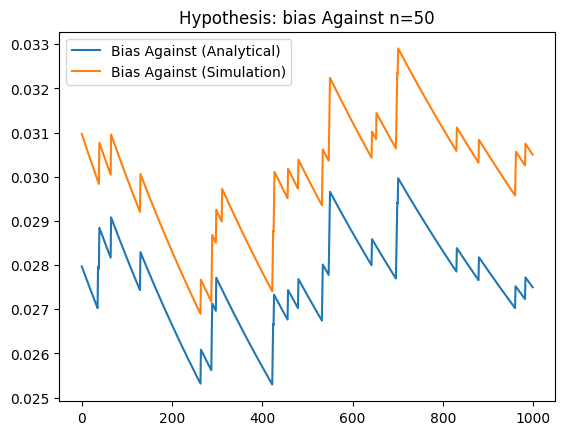

In [22]:
use = 1000  # Number of samples to use

# Extract posterior samples
theta_samples = idata.posterior['theta'].values.ravel()[:use]  # Shape (use,)
x_samples = idata.posterior['x_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], theta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pd'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: bias Against n={}".format(n))
plt.legend()


## Bias in favor

In [7]:
import pymc as pm
import numpy as np
import math

def normal_logp(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - pm.math.log(sigma) - 0.5*pm.math.log(2*np.pi)

def gamma_logp(value, alpha, beta):
    return (alpha - 1) * pm.math.log(value) - (value / beta) - alpha * pm.math.log(beta) - pm.math.log(math.gamma(alpha))

# Define prior parameters
theta_prior_mean = 0
theta_prior_tau = 1
alpha = 2
beta = 1/2

# Number of observations
n = 50
theta_0 = 1
phi_0 = 1

x = np.random.normal(theta_0, phi_0 ** -0.5, n)

delta = 0.05
# Define the model
with pm.Model() as m:
    # Priors
    theta = pm.Normal('theta', mu=theta_prior_mean, tau=theta_prior_tau)
    phi = pm.Gamma('phi', alpha=alpha, beta=beta)

    # Likelihood
    x_lowerlower = pm.Normal('x_lowerlower', mu=theta_0 - delta, sigma=1/(phi_0 - delta)**0.5, shape=n)
    x_lowerupper = pm.Normal('x_lowerupper', mu=theta_0 - delta, sigma=1/(phi_0 + delta)**0.5, shape=n)
    x_upperlower = pm.Normal('x_upperlower', mu=theta_0 + delta, sigma=1/(phi_0 - delta)**0.5, shape=n)
    x_upperupper = pm.Normal('x_upperupper', mu=theta_0 + delta, sigma=1/(phi_0 + delta)**0.5, shape=n)

    # Prior predictive data density evaluations
    prior_prior_pd_theta = pm.Deterministic("theta_prior", normal_logp(theta_0,  theta_prior_mean, theta_prior_tau**-0.5))

    # Posterior computations for phi (using conjugate prior properties)
    posterior_beta_philower = pm.Deterministic("posterior_beta_philower", beta + 0.5 * ((x_ - (theta_0 - delta))**2).sum())
    posterior_prior_pd_philower = pm.Deterministic("posterior_prior_pd_philower", (alpha + n/2) / posterior_beta_philower)

    posterior_beta_phiupper = pm.Deterministic("posterior_beta_phiupper", beta + 0.5 * ((x_ - (theta_0 + delta))**2).sum())
    posterior_prior_pd_phiupper = pm.Deterministic("posterior_prior_pd_phiupper", (alpha + n/2) / posterior_beta_phiupper)

    # Posterior computations for theta
    posterior_var_thetalowerlower = pm.Deterministic("posterior_var_thetalowerlower", 1 / (theta_prior_tau + n * posterior_prior_pd_philower))
    posterior_mean_thetalowerlower = pm.Deterministic("posterior_mean_thetalowerlower", (theta_prior_mean * theta_prior_tau + x_lowerlower.sum() * posterior_prior_pd_philower)/(theta_prior_tau + n * posterior_prior_pd_phi))
    posterior_prior_pd_thetalowerlower = pm.Deterministic("posterior_prior_pd_thetalowerlower",
                                                normal_logp(theta_0, posterior_mean_thetalowerlower, posterior_var_thetalowerlower**0.5))

    posterior_var_thetalowerupper = pm.Deterministic("posterior_var_thetalowerupper", 1 / (theta_prior_tau + n * posterior_prior_pd_phiupper))
    posterior_mean_thetalowerupper = pm.Deterministic("posterior_mean_thetalowerupper", (theta_prior_mean * theta_prior_tau + x_lowerupper.sum() * posterior_prior_pd_phiupper)/(theta_prior_tau + n * posterior_prior_pd_phiupper))
    posterior_prior_pd_thetalowerupper = pm.Deterministic("posterior_prior_pd_thetalowerupper",
                                                normal_logp(theta_0, posterior_mean_thetalowerupper, posterior_var_thetalowerupper**0.5))

    posterior_var_thetaupperlower = pm.Deterministic("posterior_var_thetaupperlower", 1 / (theta_prior_tau + n * posterior_prior_pd_philower))
    posterior_mean_thetaupperlower = pm.Deterministic("posterior_mean_thetaupperlower", (theta_prior_mean * theta_prior_tau + x_upperlower.sum() * posterior_prior_pd_philower)/(theta_prior_tau + n * posterior_prior_pd_philower))
    posterior_prior_pd_thetaupperlower = pm.Deterministic("posterior_prior_pd_thetaupperlower",
                                                normal_logp(theta_0, posterior_mean_thetaupperlower, posterior_var_thetaupperlower**0.5))

    posterior_var_thetaupperupper = pm.Deterministic("posterior_var_thetaupperupper", 1 / (theta_prior_tau + n * posterior_prior_pd_phiupper))
    posterior_mean_thetaupperupper = pm.Deterministic("posterior_mean_thetaupperupper", (theta_prior_mean * theta_prior_tau + x_upperupper.sum() * posterior_prior_pd_phiupper)/(theta_prior_tau + n * posterior_prior_pd_phiupper))
    posterior_prior_pd_thetaupperupper = pm.Deterministic("posterior_prior_pd_thetaupperupper",
                                                normal_logp(theta_0, posterior_mean_thetaupperupper, posterior_var_thetaupperupper**0.5))
    # Bayes factor for the priors
    logBR_prior_pd11 = pm.Deterministic("logBR_prior_pd11", posterior_prior_pd_thetalowerlower - prior_prior_pd_theta)
    logBR_prior_pd12 = pm.Deterministic("logBR_prior_pd12", posterior_prior_pd_thetalowerupper - prior_prior_pd_theta)
    logBR_prior_pd21 = pm.Deterministic("logBR_prior_pd21", posterior_prior_pd_thetaupperlower - prior_prior_pd_theta)
    logBR_prior_pd22 = pm.Deterministic("logBR_prior_pd22", posterior_prior_pd_thetaupperupper - prior_prior_pd_theta)

    # Likelihood prior predictive density evaluations
    likelihood_prior_pd11 = pm.Deterministic("likelihood_prior_pd11", normal_logp(x_lowerlower, theta_0, 1/phi_0**0.5).sum())# FINISH THIS
    likelihood_prior_pd12 = pm.Deterministic("likelihood_prior_pd12", normal_logp(x_lowerupper, theta_0, 1/phi_0**0.5).sum())
    likelihood_prior_pd21 = pm.Deterministic("likelihood_prior_pd21", normal_logp(x_upperlower, theta_0, 1/phi_0**0.5).sum())
    likelihood_prior_pd22 = pm.Deterministic("likelihood_prior_pd22", normal_logp(x_upperupper, theta_0, 1/phi_0**0.5).sum())

# Sample from the model
with m:
    idata = pm.sample(draws=1000)



In [10]:
def calculate_ml_biasfor(x, likelihood):
    use = 1000  # Number of samples to use

    # Extract posterior samples
    theta_samples = idata.posterior['theta'].values.ravel()[:use]  # Shape (use,)
    x_samples = x.values  # Shape (chains, draws, n)

    # Compute log likelihoods for all samples at once
    marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], theta_samples, 1).sum(axis=2)

    # Average the likelihoods over the samples
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    # Compute biases
    likelihood_prior_pd = likelihood.values.ravel()

    bias_for_ml = (likelihood_prior_pd - log_marginal_likelihoods) >= 0

    bias_for_ml_mci = bias_for_ml.cumsum() / np.arange(1, len(bias_for_ml) + 1)

    return bias_for_ml_mci

lower lower

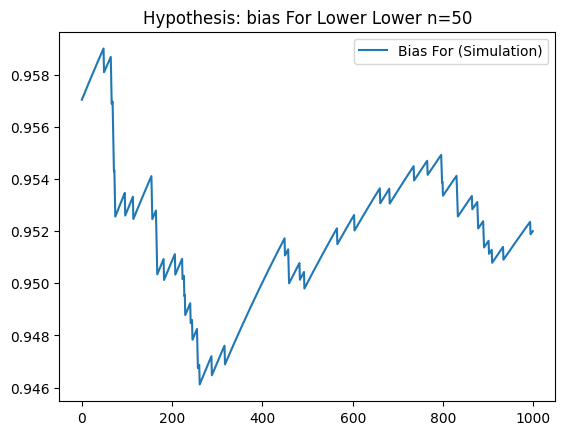

In [27]:
bias_for11 = idata.posterior["logBR_prior_pd11"].values.ravel() >= 0
t = bias_for11.shape[0]
burn = 1000
bias_for11_mci = bias_for11.cumsum() / np.arange(1, t+1)

bias_for11_ml_mci = calculate_ml_biasfor(idata.posterior['x_lowerlower'], idata.posterior['likelihood_prior_pd11'])


#plt.plot(bias_for11[burn:], label='Bias For  (Analytical)')
plt.plot(bias_for11_ml_mci[burn:], label='Bias For (Simulation)')
plt.title("Hypothesis: bias For Lower Lower n={}".format(n))
plt.legend()


Lower Upper

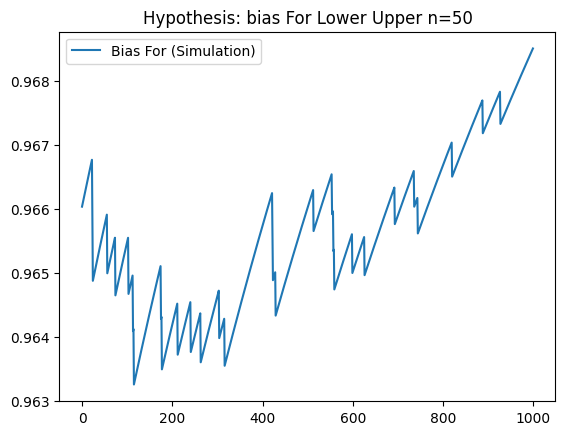

In [26]:
bias_for12 = idata.posterior["logBR_prior_pd12"].values.ravel() >= 0
t = bias_for12.shape[0]
burn = 1000
bias_for12_mci = bias_for12.cumsum() / np.arange(1, t+1)

bias_for12_ml_mci = calculate_ml_biasfor(idata.posterior['x_lowerupper'], idata.posterior['likelihood_prior_pd12'])


#plt.plot(bias_for12[burn:], label='Bias For  (Analytical)')
plt.plot(bias_for12_ml_mci[burn:], label='Bias For (Simulation)')
plt.title("Hypothesis: bias For Lower Upper n={}".format(n))
plt.legend()

Upper Lower

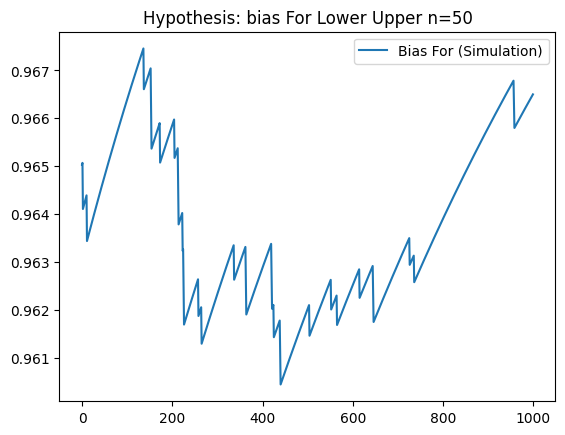

In [25]:
bias_for21 = idata.posterior["logBR_prior_pd21"].values.ravel() >= 0
t = bias_for21.shape[0]
burn = 1000
bias_for21_mci = bias_for21.cumsum() / np.arange(1, t+1)

bias_for21_ml_mci = calculate_ml_biasfor(idata.posterior['x_upperlower'], idata.posterior['likelihood_prior_pd21'])


#plt.plot(bias_for21[burn:], label='Bias For  (Analytical)')
plt.plot(bias_for21_ml_mci[burn:], label='Bias For (Simulation)')
plt.title("Hypothesis: bias For Lower Upper n={}".format(n))
plt.legend()

Upper Upper

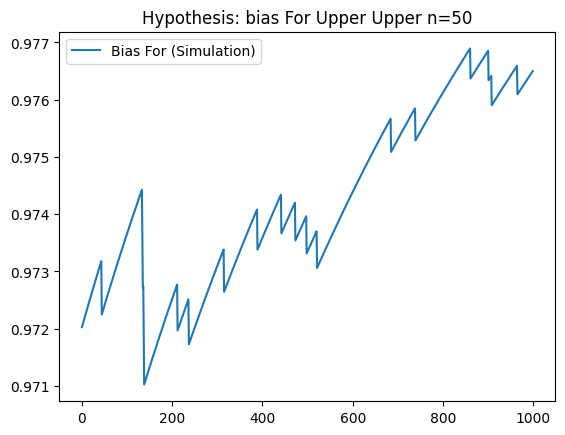

In [24]:
bias_for22 = idata.posterior["logBR_prior_pd22"].values.ravel() >= 0
t = bias_for22.shape[0]
burn = 1000
bias_for22_mci = bias_for22.cumsum() / np.arange(1, t+1)

bias_for22_ml_mci = calculate_ml_biasfor(idata.posterior['x_upperupper'], idata.posterior['likelihood_prior_pd22'])


#plt.plot(bias_for22[burn:], label='Bias For  (Analytical)')
plt.plot(bias_for22_ml_mci[burn:], label='Bias For (Simulation)')
plt.title("Hypothesis: bias For Upper Upper n={}".format(n))
plt.legend()

# Estimation

In [1]:
import pymc as pm
import numpy as np
import math

def normal_logp(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - pm.math.log(sigma) - 0.5*pm.math.log(2*np.pi)

def gamma_logp(value, alpha, beta):
    return (alpha - 1) * pm.math.log(value) - (value / beta) - alpha * pm.math.log(beta) - pm.math.log(math.gamma(alpha))

# Define prior parameters
theta_prior_mean = 0
theta_prior_tau = 1
alpha = 2
beta = 1/2

# Number of observations
n = 50
theta_0 = 1
phi_0 = 1

x = np.random.normal(theta_0, phi_0 ** -0.5, n)

# Define the model
with pm.Model() as m:
    # Priors
    theta = pm.Normal('theta', mu=theta_prior_mean, tau=theta_prior_tau)
    phi = pm.Gamma('phi', alpha=alpha, beta=beta)

    # Likelihood
    x_ = pm.Normal('x_', mu=theta, sigma=1/phi**0.5, shape=n) #Uses calculated priors instead of initial parameters

    # Prior predictive data density evaluations

    prior_prior_pd_theta = pm.Deterministic("theta_prior", normal_logp(theta,  theta_prior_mean, theta_prior_tau**-1))

    # Posterior computations for phi (using conjugate prior properties)
    posterior_beta_phi = pm.Deterministic("posterior_beta_phi", beta + 0.5 * ((x_ - theta_0)**2).sum())
    posterior_prior_pd_phi = pm.Deterministic("posterior_prior_pd_phi", (alpha + n/2) / posterior_beta_phi)

    # Posterior computations for theta
    posterior_var_theta = pm.Deterministic("posterior_var_theta", 1 / (theta_prior_tau + n * posterior_prior_pd_phi))
    posterior_mean_theta = pm.Deterministic("posterior_mean_theta", (theta_prior_mean * theta_prior_tau + x_.sum() * posterior_prior_pd_phi)/(theta_prior_tau + n * posterior_prior_pd_phi))
    posterior_prior_pd_theta = pm.Deterministic("posterior_prior_pd_theta",
                                                normal_logp(theta, posterior_mean_theta, posterior_var_theta**0.5))

    # Bayes factor for the priors
    logBR_prior_pd = pm.Deterministic("logBR_prior_pd", posterior_prior_pd_theta - prior_prior_pd_theta)

    # Likelihood prior predictive density evaluations
    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", normal_logp(x_, theta, 1/phi**0.5).sum())

# Sample from the model
with m:
    idata = pm.sample(draws=1000)

bias_against = idata.posterior["logBR_prior_pd"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)


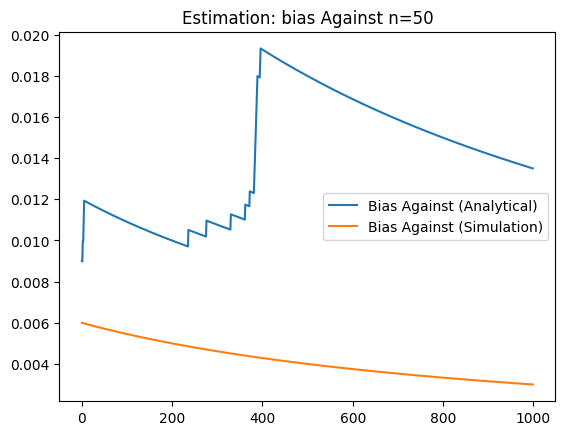

In [4]:
use = 1000  # Number of samples to use

# Extract posterior samples
theta_samples = idata.posterior['theta'].values.ravel()[:use]  # Shape (use,)
x_samples = idata.posterior['x_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], theta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pd'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Estimation: bias Against n={}".format(n))
plt.legend()
